In [50]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import learning_curve
from xgboost import XGBRegressor


## Load clean prepared data

In [23]:
import os
import sys
from google.colab import drive

try:
  drive.mount('/content/drive')
  project_path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - USA HOUSE PRICES"
  sys.path.append(os.path.join(project_path, "src"))

  path = "/content/drive/MyDrive/Pytorch pet projects/ML - Projects/ML - USA HOUSE PRICES/data/processed/processed_data.csv"
except:
  path = "../data/processed/processed_data.csv"



df = pd.read_csv(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4344 entries, 0 to 4343
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Avg. Area Income              4344 non-null   float64
 1   Avg. Area House Age           4344 non-null   float64
 2   Avg. Area Number of Rooms     4344 non-null   float64
 3   Avg. Area Number of Bedrooms  4344 non-null   float64
 4   Area Population               4344 non-null   float64
 5   Price                         4344 non-null   float64
dtypes: float64(6)
memory usage: 203.8 KB


## Split into Train-test

In [25]:
X = df.drop(columns=["Price"])
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## Create pipline

In [51]:
numerical_features = X_train.select_dtypes(include=["float64"]).columns
numerical_transform = Pipeline([
                               ("scaler", StandardScaler())
                               ])

preprocessor = ColumnTransformer([
    ("num", numerical_transform, numerical_features)
])

model = Pipeline([
    ("preprocessor", preprocessor),
    ("regressor", XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.1, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Performance:\nMAE: {mae:.2f}\nRMSE: {rmse:.2f}\nR²: {r2:.4f}")


Model Performance:
MAE: 91721.68
RMSE: 113577.32
R²: 0.8932


## Learning Curve

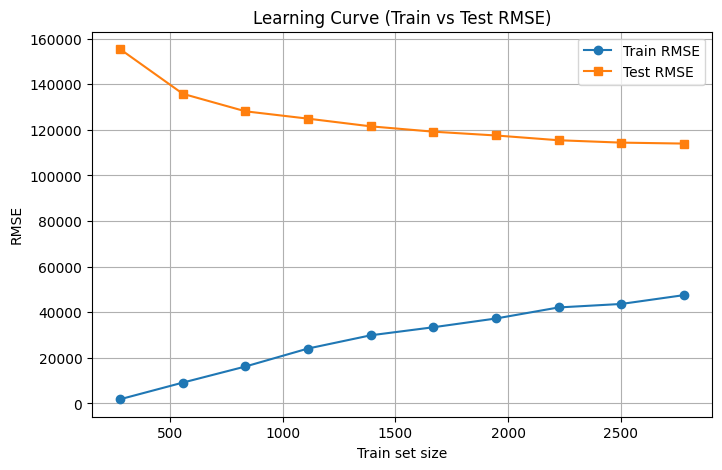

In [52]:
train_sizes, train_scores, test_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = -np.mean(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Train RMSE", marker="o")
plt.plot(train_sizes, test_mean, label="Test RMSE", marker="s")

plt.xlabel("Train set size")
plt.ylabel("RMSE")
plt.title("Learning Curve (Train vs Test RMSE)")
plt.legend()
plt.grid()
plt.show()

## Check feature importances

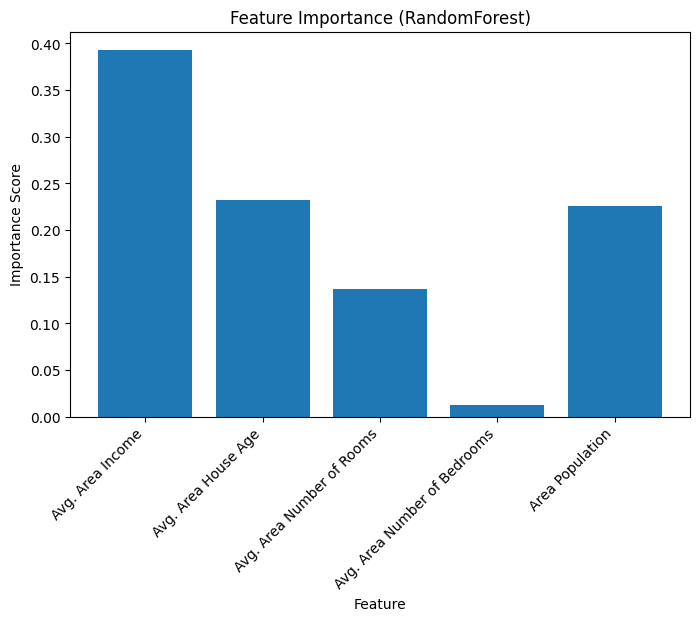

In [53]:
rf_model = model.named_steps["regressor"]
feature_importance = rf_model.feature_importances_

plt.figure(figsize=(8,5))
plt.bar(range(len(feature_importance)), feature_importance, align="center")
plt.xticks(range(len(feature_importance)), np.array(numerical_features), rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importance (RandomForest)")
plt.show()

## Save the model

In [54]:
joblib.dump(model, "house_price_model.pkl")

['house_price_model.pkl']